<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_SLSTR_advanced/2_1_SLSTR_advanced_data_access_eumdac.ipynb" target="_blank"><< Advanced SLSTR data access with the EUMDAC client</a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT <br>
**Authors:** <a href=mailto:copernicus.training@eumetsat.int target="_blank">Ben Loveday (EUMETSAT/Innoflair UG)</a>, Gary Corlett (EUMETSAT), Hayley Evers-King (EUMETSAT)

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-slstr/HEAD?urlpath=%2Ftree%2F2_SLSTR_advanced%2F2_2_SLSTR_channel_comparison_cloud_flagging.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn SLSTR: Advanced</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
Users should review the following notebooks for more information on setting up a credentials files for using the eumdac python library to retrieve SLSTR data from the Data Store:
    
- **<a href="../1_SLSTR_introductory/1_1a_SLSTR_data_access_Data_Store.ipynb">1_1a_SLSTR_data_access_Data_Store.ipynb</a>**

You will also need to have registered for a **<a href="https://eoportal.eumetsat.int/" target="_blank">A EUMETSAT Earth Observation Portal account</a>** to download from the EUMETSAT Data Store.

</div>
<hr>

# 2.2 SLSTR channel comparison and cloud flagging

### Data used

| Product Description | Data Store collection ID | More information |
|:--------------------:|:-----------------------:|:-------------:|
| Sentinel-3 SLSTR level-1B  | EO:EUM:DAT:0411 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SL_1_RBT___NTC?query=slstr&&results=24&s=advanced" target="_blank">link</a> |
| CMEMS global ocean OSTIA diurnal skin SST | SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014 | <a href="https://resources.marine.copernicus.eu/product-detail/SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014/INFORMATION" target="_blank">link</a> |
| CMEMS global ocean OSTIA foundation SST | SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001 | <a href="https://resources.marine.copernicus.eu/product-detail/SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001/INFORMATION" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will;
* know what data is available at different levels of SST processing
* be aware of the difference between solar and thermal channels
* understand the importance and practical basis of cloud masking

### Outline

The Agulhas, like all western boundary currents, transports immense amounts of warm water polewards. From it's eddy-rich source regions of the Mozambique channel (MZC) and South East Madagascar Current (SEMC) (Figure 1a), to the boundary current proper, Agulhas retroflection (Figure 1b) and return current, we can see the imprint of these warm waters in the sea surface temperature (SST). Through the SST record we can examine the extensive spatio-temporal variability of the Agulhas system; identifying phenomena such as eddies, filaments, solitary meanders (Figure 1c), and, occasionally, rings ejected from the retroflection.

<table><tr>
<td> <img src="../img/ag2.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="../img/ag1.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="../img/ag3.png" alt="Drawing" style="width: 300px;"/> </td>
<caption>Figure 1: Examples of mesoscale variability in the regional Level-2 SLSTR SST signal, captured using <a href="https://view.eumetsat.int/" target="_blank">EUMETVIEW</a>. From left to right the panels show (a) eddies in the MZC and SEMC source regions, (b) inshore eddies in the southern Agulhas Current and (c) Solitary meanders</caption>
</tr></table>

Satellites provide an essential way for us to monitor SST on a synoptic and mesoscale scale. In this notebook we are going to examine the practical ways in which we can actually do this, with a focus on the Sea and Land Surface Thermal Radiometer **<a href="https://eumetsatspace.atlassian.net/wiki/spaces/SEN3/pages/1598193706/Sea+Land+Surface+Temperature+Radiometer+SLSTR" target="_blank">(SLSTR)</a>** sensor aboard the Copernicus Sentinel-3 satellites, operated by EUMETSAT. We will show you how we can access data for the region and how we can manipulate it in Python. We will discuss the differences between solar reflectance and thermal channels, showing how we can use the former to facilitate cloud masking. Lastly, we will look at the differences between SST products at various levels of processing, briefly discussing the consequences and advantages of entering at different levels of the satellite processing chain.


Before we begin you should note that this notebook can be launched on a remote server using Binder by using the button at the top of the page. Alternatively, you can run it locally by cloning the **<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-slstr" target="_blank">learn-slstr</a>** repository. The README file will fully describe how to create an appropriate Python environment to run this code.

**Note: to download the required SLSTR data, you will need to register for an EOP account. Please see the prerequisites for more information on how to do this**

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
0. [Step 0: A quick preamble in functions](#section0)
1. [Step 1: Acquiring SLSTR level-1B data](#section1)
1. [Step 2: Reading in the radiance and brightness temperature data](#section2)
1. [Step 3: Comparing visible and thermal channel data](#section3)
1. [Step 4: Characterising the atmosphere](#section4)
1. [Step 5: Developing cloud masks](#section5)
1. [Step 6: Comparing the level-2 and level-4 data](#section6)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
import cartopy                          # a library that support mapping
import datetime                         # a libary that allows us to work with dates and times
import time                             # a library that gives us the ability to pause a script briefly
import xarray as xr                     # a library that supports the use of multi-dimensional arrays in Python
import glob                             # a library that aids in searching for files
import json                             # a library that helps us make JSON format files
import numpy as np                      # a library that lets us work with arrays; we import this with a new name "np"
import os                               # a library that allows us access to basic operating system commands
import shutil                           # a library that allows us access to basic operating system commands like copy
import zipfile                          # a library that allows us to unzip zip-files.
import matplotlib.pyplot as plt         # a library that support plotting
import matplotlib.ticker as mticker     # a library that extends plotting support
from shapely.geometry import Polygon    # a library that helps us work with shape objects
from scipy.interpolate import griddata  # a library that supports irregular grid interpolation
import xml.etree.ElementTree as ET      # a library that helps us parse XML files
import eumdac                           # a tool that helps us download via the eumetsat/data-store
import eumartools                       # a EUMETSAT library that support working with Sentinel-3 products

Next we will create a download directory to store the products we will download in this notebook.

In [2]:
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. A quick preamble on functions
[Back to top](#TOC_TOP)

</div>

Before we start the notebook proper, we will define a quick function that we will use throughout. The function is quite simple and just adds embellishments (gridlines, labels etc) to plots.

In [3]:
def embellish_plot(m):
    """Quick function to embellish SLSTR plots with gridlines and labels

    Args:
        m (axis): the axis to plot into
    Returns:
        None
    """
    # Embellish with gridlines
    g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
    g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
    g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'color': 'black'}
    g1.ylabel_style = {'color': 'black'}
    m.set(facecolor = "1.0")
    m.axis('off')

<div class="alert alert-info" role="alert">

## <a id='section1'></a>Step 1: Acquiring SLSTR level-1B data
[Back to top](#TOC_TOP)

</div>

Now we begin with our first task, data access. For this we will use the **<a href="https://data.eumetsat.int" target="_blank">EUMETSAT Data Store</a>** to retrieve our required SLSTR data. However, before we use the Data Store to download data, we must first authenticate our access and retrieve an access token. More **essential** information on setting this up can be found in the **<a href="../1_SLSTR_introductory/1_1a_SLSTR_data_access_Data_Store.ipynb">1_1a_SLSTR_data_access_Data_Store</a>** notebook.

We are going to use the `eumdac` Python package to set up to help us with authentication and data access via API. By default we will read our credentials from a file that we must create. If you would rather enter these credentials directly, please set `file_credentials = False` and read the red box!

In [4]:
# load credentials
file_credentials = True

if file_credentials == True:
    with open(os.path.join(os.path.expanduser("~"),'.eumdac_credentials')) as json_file:
        credentials = json.load(json_file)
        token = eumdac.AccessToken((credentials['consumer_key'], credentials['consumer_secret']))
        print(f"This token '{token}' expires {token.expiration}")
else:
    # see below for more information
    token = eumdac.AccessToken(("consumer_key", "consumer_secret"))

# create data store object
datastore = eumdac.DataStore(token)

This token 'd1eef306-d59f-382e-a931-79db534916e1' expires 2023-07-05 13:12:34.413179


<div class="alert alert-danger" role="alert">

*Note: You can generate a token directly by entering your key and secret in the notebook as follows*

`token = eumdac.AccessToken(("consumer_key", "consumer_secret"))`

*However, while this method is convenient in the short term, but is not really recommended as you have to put your key and secret in this notebook, and run the risk of accidentally sharing them. This method also requires you to authenticate on a notebook-by-notebook basis.*
    
</div>

We will work with the SLSTR level-1B data throughout this notebook. To retrieve this, we need to know the **collection ID** for this data type, which is `EO:EUM:DAT:0411`. You can find this information on the Data Store itself, or you can ask the `eumdac` client to tell you all the avaiable collections by calling the `eumdac.DataStore(token).collections` method.

We can use our collection ID to create a collection object (`selected_collection`) and ask for more information on the collection as follows.

In [5]:
# set collection ID for SLSTR level-1B
collectionID = 'EO:EUM:DAT:0411'

# Use collection ID
selected_collection = datastore.get_collection(collectionID)
print(f"{selected_collection.title}\n---\n{selected_collection.abstract}")

SLSTR Level 1B Radiances and Brightness Temperatures - Sentinel-3
---
The SLSTR level 1 products contain: the radiances of the 6 visible (VIS), Near Infra-Red (NIR) and Short Wave Infra-Red (SWIR) bands (on the A and B stripe grids); the Brightness Temperature (BT) for the 3 Thermal Infra-Red (TIR) bands; the BT for the 2 Fire (FIR) bands. Resolution: 1km at nadir (TIR), 500m (VIS). All are provided for both the oblique and nadir view. These measurements are accompanied with grid and time information, quality flags, error estimates and meteorological auxiliary data. - All Sentinel-3 NRT products are available at pick-up point in less than 3h - All Sentinel-3 Non Time Critical (NTC) products are available at pick-up point in less than 30 days. Sentinel-3 is part of a series of Sentinel satellites, under the umbrella of the EU Copernicus programme.


Now we have defined our collection, and from the metadata it looks correct, we can request products from it. In this case we are interested in the specific `productID` defined below. This is a single non-time critical, level-1B SLSTR granule.

In [6]:
productID = 'S3B_SL_1_RBT____20220318T075037_20220318T075337_20220319T164550_0179_063_377_3600_MAR_O_NT_004.SEN3'
selected_product = datastore.get_product(product_id=productID, collection_id=collectionID)

Now we have defined our product, we will download it, unzip it, and clear up the latent zip file. The box below will manage this process for us.

In [7]:
# Download the product
with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
    print(f'Downloading {fsrc.name}')
    shutil.copyfileobj(fsrc, fdst)
    print(f'Download of product {fsrc.name} finished.')

# Unzip the product
with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.startswith(str(selected_product)):
            zip_ref.extract(file, download_dir)
    print(f'Unzipping of product {selected_product} finished.')

# Clean up
os.remove(fdst.name)

Download of product S3B_SL_1_RBT____20220318T075037_20220318T075337_20220319T164550_0179_063_377_3600_MAR_O_NT_004.SEN3.zip finished.
Unzipping of product S3B_SL_1_RBT____20220318T075037_20220318T075337_20220319T164550_0179_063_377_3600_MAR_O_NT_004.SEN3 finished.


We will also download a few other products, but in this case we will **only**  retrieve the the `xfdumanifest.xml` file that gives us some metadata information on the product. These are very small, but will allow us to plot the extents of a few granules without gathering all of the data.

In [9]:
productIDs = ['S3B_SL_1_RBT____20220318T214831_20220318T215131_20220320T063651_0179_063_385_5400_MAR_O_NT_004.SEN3',
              'S3B_SL_1_RBT____20220318T214531_20220318T214831_20220320T063542_0179_063_385_5220_MAR_O_NT_004.SEN3',
              'S3A_SL_1_RBT____20220318T204657_20220318T204957_20220320T044554_0179_083_142_5400_MAR_O_NT_004.SEN3',
              'S3A_SL_1_RBT____20220318T204357_20220318T204657_20220320T044445_0179_083_142_5220_MAR_O_NT_004.SEN3',
              'S3B_SL_1_RBT____20220318T200732_20220318T201032_20220320T043253_0179_063_384_5400_MAR_O_NT_004.SEN3',
              'S3A_SL_1_RBT____20220318T083003_20220318T083303_20220319T165622_0180_083_135_3600_MAR_O_NT_004.SEN3',
              'S3A_SL_1_RBT____20220318T082703_20220318T083003_20220319T165513_0179_083_135_3420_MAR_O_NT_004.SEN3',
              'S3B_SL_1_RBT____20220318T074737_20220318T075037_20220319T164449_0179_063_377_3420_MAR_O_NT_004.SEN3',
              'S3A_SL_1_RBT____20220318T064903_20220318T065203_20220319T142954_0179_083_134_3600_MAR_O_NT_004.SEN3',
              'S3B_SL_1_RBT____20220318T075037_20220318T075337_20220319T164550_0179_063_377_3600_MAR_O_NT_004.SEN3']
              
for productID, count in zip(productIDs, range(len(productIDs))):
    selected_product = datastore.get_product(product_id=productID, collection_id=collectionID)
    for entry in selected_product.entries:
        if 'xfdumanifest.xml' in entry:
            with selected_product.open(entry=entry) as fsrc, open(os.path.join(os.getcwd(), 'products', 
                                                        fsrc.name.replace('.xml', f"{str(count).zfill(2)}.xml")),
                                                        mode='wb') as fdst:
                print(f'Downloading {fsrc.name}.')
                shutil.copyfileobj(fsrc, fdst)
                print(f'Download of file {fsrc.name} finished.')
    time.sleep(1)

Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.
Download of file xfdumanifest.xml finished.


If all went well, your products are now downloaded. You can find them in the `products` directory in the same folder as this notebook. Now we have all of our data, we can proceed to using it.

<div class="alert alert-info" role="alert">

## <a id='section2'></a>Step 2: Reading in the radiance and brightness temperature data
[Back to top](#TOC_TOP)

</div>

SLSTR contains data in 11 bands. Six of these (S1-S6) are solar radiance channels, which measure the reflected signal from the sun at defined wavelengths. Three (S7-S9) are thermal infrared (TIR) channels, with measure the brightness temperature emmitted by a surface (ocean/land/atmosphere) at a defined wavelength. The final two (F1/F2) are fire channels, which we will not use here.

We are going to read 4 of the solar channels, and 2 of the TIR channels, as defined below.

In [10]:
# read all the bands from our products: nadir and a-stripe
solar_channels = [1,2,3,5]
TIR_channels = [7,9]

In order to read the data in, we must first point to it. The box below will define the path to our input directory, the **<a href="https://eumetsatspace.atlassian.net/wiki/spaces/DPF/pages/1611497502/Sentinel-SAFE+file+format" target="_blank">SAFE</a>** format SLSTR Level-1B granule we downloaded in Step 1.

In [11]:
# selecting SAFE directory:
SAFE_directory = os.path.join(os.getcwd(), 'products', 
    'S3B_SL_1_RBT____20220318T075037_20220318T075337_20220319T164550_0179_063_377_3600_MAR_O_NT_004.SEN3')

If you look inside the directory we defined, you will find that there are a number of files. Below, we will read in the "geodetic grid" coordinates for our products, allowing us to plot them against latitude and longitude later on.

*Note: SLSTR products are recorded on various grids. For more information see the <a href="../1_SLSTR_introductory/1_4_SLSTR_bands_imagery.ipynb">1_4_SLSTR_bands_imagery</a> notebook.*

In [12]:
# read geodetic grids
coords_dict = {}
for coords in ["io", "in", "an"]:
    coords_file = xr.open_mfdataset(os.path.join(SAFE_directory, f'geodetic_{coords}.nc'))
    coords_dict[f"longitude_{coords}"] = np.array(coords_file[f"longitude_{coords}"].data)
    coords_dict[f"latitude_{coords}"] = np.array(coords_file[f"latitude_{coords}"].data)
    coords_file.close()

# calculate "io" extents for later use
extents = [np.nanmin(coords_dict["longitude_io"]),
           np.nanmax(coords_dict["longitude_io"]),
           np.nanmin(coords_dict["latitude_io"]),
           np.nanmax(coords_dict["latitude_io"])]

Next we will read in the data. The box below looks rather complex, but actually just iterates through the various files in the product directory to read the radiance and brightness temperatures we need from the relevant channels as well as the flags we need to quality control the data. It will pack all of this information in a Python "dictionary" which is a convenient way for us to store all the variables together for later use.

In [15]:
# open data
band_dict = {}

# read file
for pattern, bands_needed, flag_file, flag_var in zip(['S*radiance_an.nc', 'S*BT_in.nc', 'S*BT_io.nc'], 
                                                 [solar_channels, TIR_channels, TIR_channels],
                                                 ["flags_an.nc", "flags_in.nc", "flags_io.nc"],
                                                 ["confidence_an", "confidence_in", "confidence_io"]):
    band_files = glob.glob(os.path.join(SAFE_directory, pattern))
    band_vars = xr.open_mfdataset(band_files)

    # read variables
    for band_var in band_vars:
        band_num = int(band_var.split('_')[0][1])
        if band_num in bands_needed and "exception" not in band_var and "orphan" not in band_var:
            print(f"Reading:  {band_var}")
            band_dict[band_var] = band_vars[band_var].data

    # add flags
    flag_path = glob.glob(os.path.join(SAFE_directory, flag_file))[0]        
    print(f"Reading:  {flag_var} (flags)")
    band_dict[flag_file.replace(".nc","_cloud")] = eumartools.flag_mask(flag_path, 
                                                                        flag_var, ["summary_cloud"], dtype=np.uint64)
    band_dict[flag_file.replace(".nc","_ocean")] = eumartools.flag_mask(flag_path, 
                                                                        flag_var, ["ocean"], dtype=np.uint64)
    band_dict[flag_file.replace(".nc","_land")]  = eumartools.flag_mask(flag_path, 
                                                                        flag_var, ["land"], dtype=np.uint64)

Reading:  S1_radiance_an
Reading:  S2_radiance_an
Reading:  S3_radiance_an
Reading:  S5_radiance_an
Reading:  confidence_an (flags)
Reading:  S7_BT_in
Reading:  S9_BT_in
Reading:  confidence_in (flags)
Reading:  S7_BT_io
Reading:  S9_BT_io
Reading:  confidence_io (flags)


Ok, now we have everything we need! Lets take a look at the data itself.

<div class="alert alert-info" role="alert">

## <a id='section3'></a>Step 3: Comparing visible and thermal channel data
[Back to top](#TOC_TOP)

</div>

The first thing we will do is compare the radiance data we get from the visible channels (S1/S2/S3) with the brightness temperature data from a thermal channel (S9). This will begin start to highlight the value of viewing in the infrared.

The box below will define an RGB array, arranging our visible channels into an array that we can use to plot, and performing some light 'tinkering' on the image to make it more appealing to the eye.

In [16]:
# False colour solar channels
red_recipe = np.array(band_dict['S3_radiance_an'])
green_recipe = np.array(band_dict['S2_radiance_an'])
blue_recipe = np.array(band_dict['S1_radiance_an'])

rgb_fsc_321 = np.dstack((red_recipe, green_recipe, blue_recipe))
rgb_fsc_321 = eumartools.normalise_image(rgb_fsc_321, unhitch=False)
rgb_fsc_321 = eumartools.truncate_image(rgb_fsc_321, min_percentile=5.0, max_percentile=95.0)
band_dict["rgb_fsc_321"] = eumartools.histogram_image(rgb_fsc_321, nbins=2048)

Now we have everything prepared, lets plot the visible RGB and single channel TIR images side by side. The code below will do that for us.

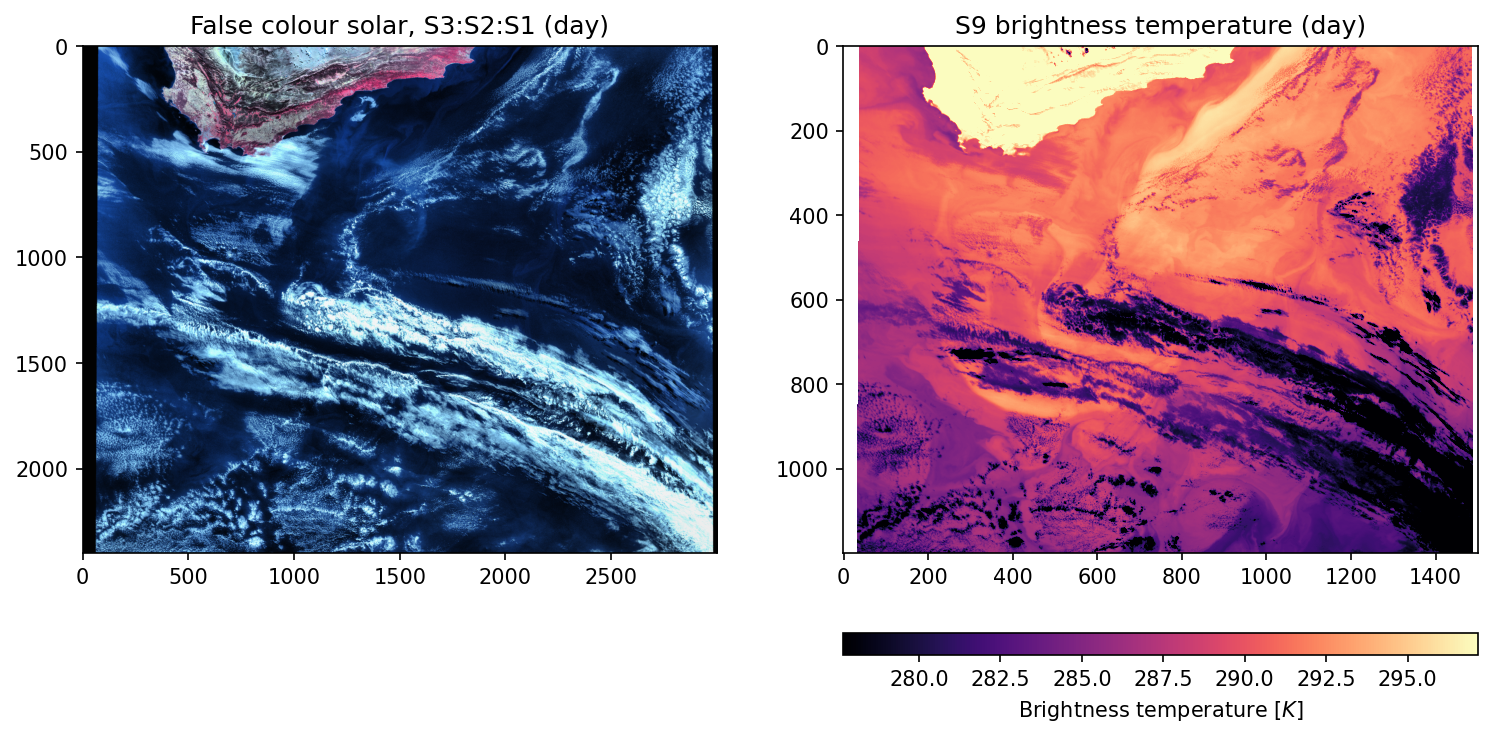

In [17]:
# plot S1:S2:S3 RGB and S9 TIR side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150)
axs[0].imshow(band_dict["rgb_fsc_321"])
axs[0].title.set_text('False colour solar, S3:S2:S1 (day)')

vmin, vmax = [np.nanpercentile(np.array(band_dict['S9_BT_in']), 5),
              np.nanpercentile(np.array(band_dict['S9_BT_in']), 95)]

c = axs[1].imshow(band_dict['S9_BT_in'], cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[1].title.set_text('S9 brightness temperature (day)')
cb_ax = fig.add_axes([axs[1].get_position().x0, 0.10, axs[1].get_position().width, 0.025])
fig.colorbar(c, cax=cb_ax, orientation="horizontal", label='Brightness temperature [$K$]');

<div class="alert alert-block alert-warning">

### Challenge:

What differences do you notice between the two? What visible signals can you see in the ocean versus the TIR?
<div>

* The visible channel RGB makes the clouds and land clear, but it is hard to distinguish any ocean features
* In the TIR image we can clearly see the warm Agulhas Current, some mesoscale features in the ocean and hints of upwelling along the West Coast.
* However, it is hard to use the TIR to discriminate between cold water signals and cloud, and warm water signals and land.

<div class="alert alert-info" role="alert">

## <a id='section4'></a>Step 4: Characterising the atmosphere
[Back to top](#TOC_TOP)

</div>

SLSTR is a dual view instrument. By that we mean that it observes the sea surface in two geometries; nadir and oblique. The nadir view looks directly down beneath the satellite. The oblique view looks "behind" the satellite. Why do we do this?

The answer is that it allows us to view the same target twice, but with different paths through the atmosphere. Removing the influence of the atmosphere (e.g through water vapour, dust, aerosols) is a major task in processing level-B data into a useable SST product.

To demonstrate the effect of the atmosphere can have; in the box below, we will plot the nadir and oblique views of the S9 TIR channel side-by-side. This time we will map these products, as the two views have different swath widths and this makes comparison easier.

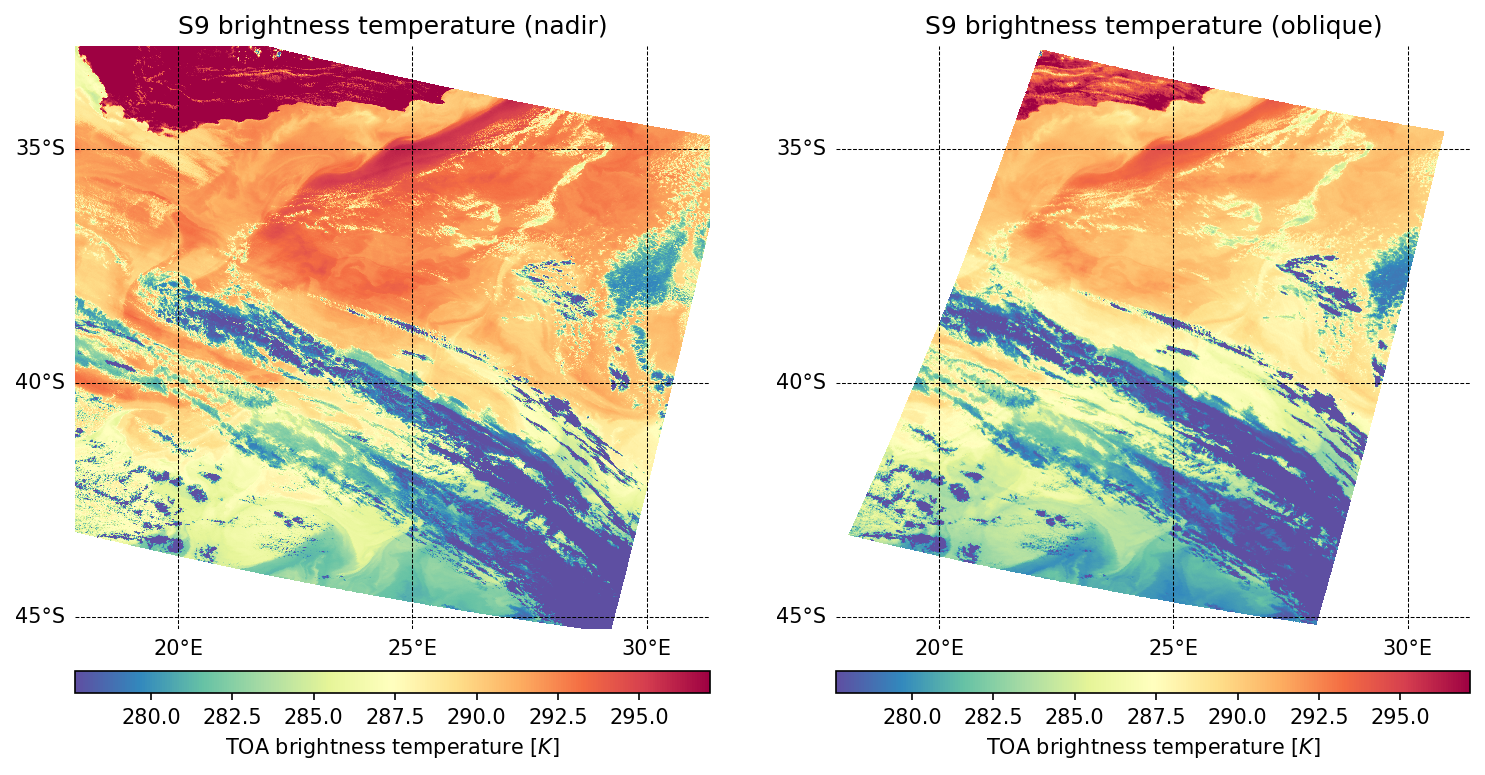

In [18]:
# plot S9 nadir and S9 oblique by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150, subplot_kw={"projection": cartopy.crs.PlateCarree()})
titles = ['S9 brightness temperature (nadir)', 'S9 brightness temperature (oblique)']
labels = ['TOA brightness temperature [$K$]', 'TOA brightness temperature [$K$]']
views = ['in', 'io']

vmin, vmax = [np.nanpercentile(np.array(band_dict['S9_BT_in']), 5),
              np.nanpercentile(np.array(band_dict['S9_BT_in']), 95)]

for m, label, title, view in zip(axs, labels, titles, views):
    c = m.pcolormesh(coords_dict[f"longitude_{view}"],
                      coords_dict[f"latitude_{view}"],
                      band_dict[f"S9_BT_{view}"],
                      transform=cartopy.crs.PlateCarree(central_longitude=0.0),
                      cmap=plt.cm.Spectral_r, vmin=vmin, vmax=vmax)
    m.set_extent(extents, crs=cartopy.crs.PlateCarree())
    m.title.set_text(title)
    embellish_plot(m)    
    cb_ax = fig.add_axes([m.get_position().x0, 0.100, m.get_position().width, 0.025])
    fig.colorbar(c, cax=cb_ax, orientation="horizontal", label=label)

<div class="alert alert-block alert-warning">

### Challenge:

The two views are plotted on an identical colour scale. What differences, other than coverage, do you see between the two?
<div>

* The brightness temperatures in the oblique view are cooler than in the nadir view due to enhanced absorption through the longer atmospheric path length.

<div class="alert alert-danger" role="alert">

## A quick aside; a word of warning!
    
</div>

Although we have three TIR channels available to us, we cannot use all of them in every circumstance. Below we will compare the S7 (3.8 $\mu m$) oblique and S9 (12 $\mu m$) oblique views side by side.

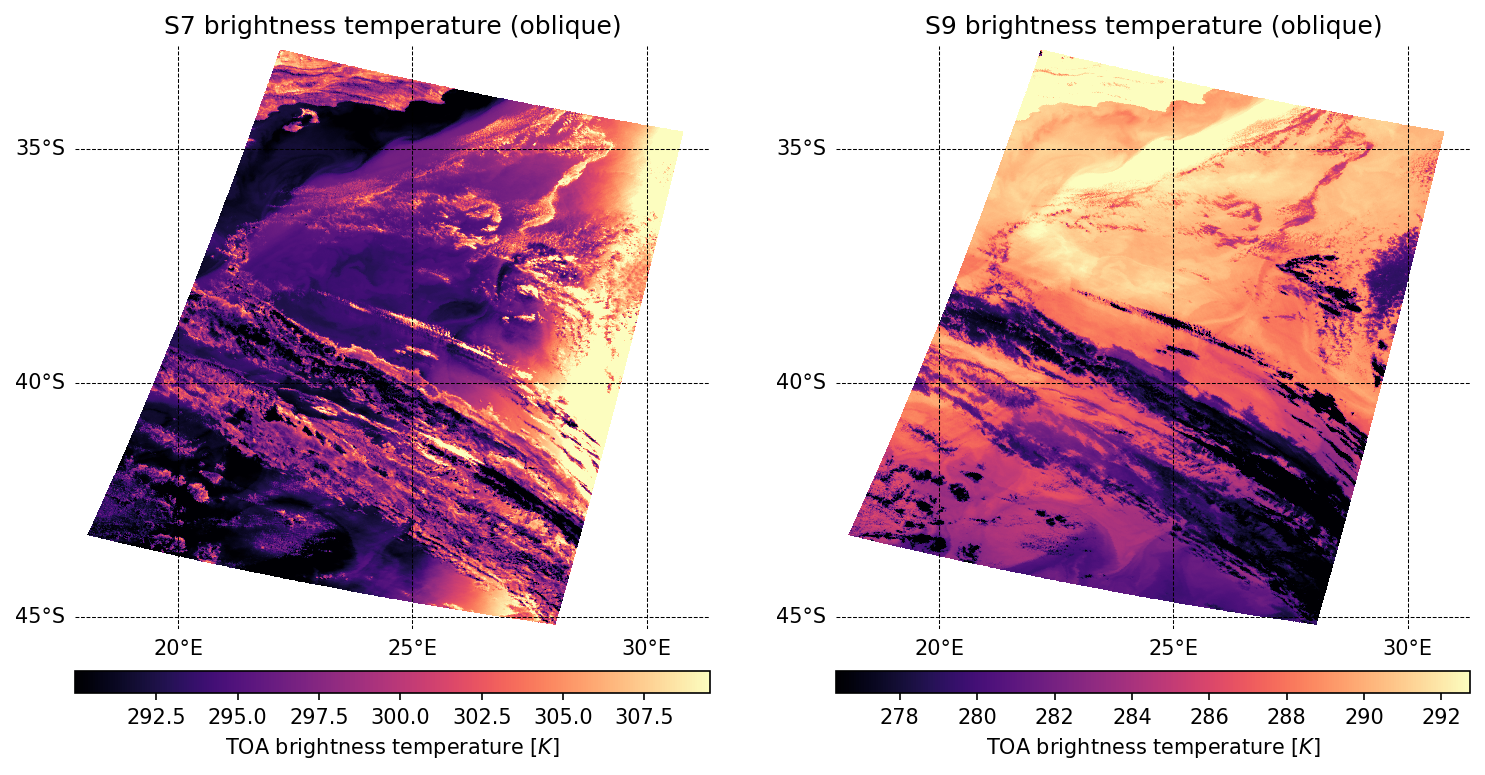

In [19]:
# plot S7 oblique and S9 oblique by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150, subplot_kw={"projection": cartopy.crs.PlateCarree()})
titles = ['S7 brightness temperature (oblique)', 'S9 brightness temperature (oblique)']
labels = ['TOA brightness temperature [$K$]', 'TOA brightness temperature [$K$]']
bands = ['S7_BT_io', 'S9_BT_io']

for m, label, title, band in zip(axs, labels, titles, bands):
    
    vmin, vmax = [np.nanpercentile(np.array(band_dict[band]), 5),
              np.nanpercentile(np.array(band_dict[band]), 95)]

    c = m.pcolormesh(coords_dict[f"longitude_io"],
                      coords_dict[f"latitude_io"],
                      band_dict[band],
                      transform=cartopy.crs.PlateCarree(central_longitude=0.0),
                      cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
    m.set_extent(extents, crs=cartopy.crs.PlateCarree())
    m.title.set_text(title)
    embellish_plot(m)    
    cb_ax = fig.add_axes([m.get_position().x0, 0.100, m.get_position().width, 0.025])
    fig.colorbar(c, cax=cb_ax, orientation="horizontal", label=label)

<div class="alert alert-block alert-warning">

### Challenge:

What do you notice happening in the S7 channel? Why would this be?
<div>

* During the day, the S7 TIR channel is contaminated with solar radiance! Due to the viewing angle of the satellite, and the fact that it is in a sun-synchronous orbit, the sun is always to the "east" of the instrument and so the eastern side of the the swath is always the worst affected (similar to "glint" if you work with ocean colour).
* There is no solar radiance at 12 $\mu m$, and so the S9 band is no contaminated.
* As a consequence, we can only use S8 and S9 to derive SST during the day.

<div class="alert alert-info" role="alert">

## <a id='section5'></a>Step 5: Developing cloud masks
[Back to top](#TOC_TOP)

</div>

Identifying and removing clouds is essential to retrieving accurate sea surface temperatures. However, this is a challenging task. During it's processing every SLSTR scene is subjected to a number of spectral, spatial and statistical tests to identify cloud. This is summarised in the `summary_cloud` flag that we have stored as *flag_in_cloud* (note; here "in" refers to the grid).

Using the code below, let us compare how the S9 channel (in nadir view) looks unflagged, with how it looks with all of these cloud flags applied. 

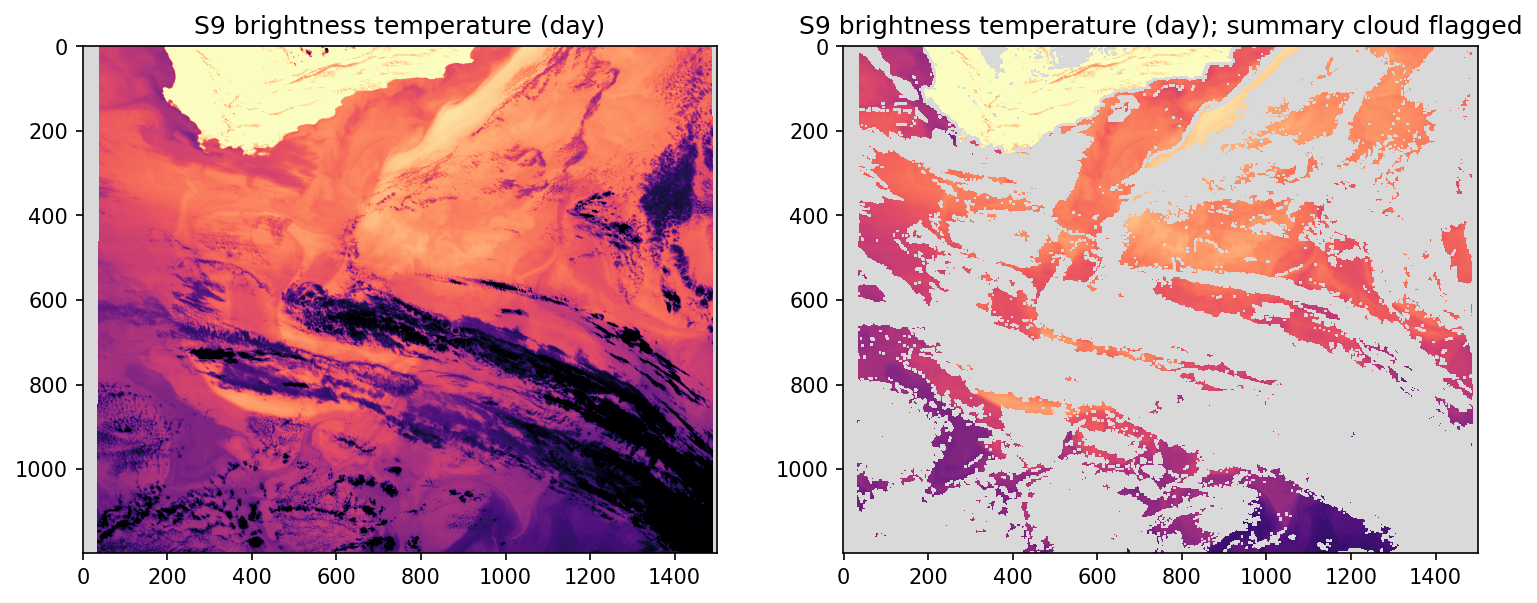

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10), dpi=150)
cloud_var = np.array(band_dict[f"S9_BT_in"])
vmin, vmax = [np.nanpercentile(cloud_var, 5), np.nanpercentile(cloud_var, 95)]
cloud_var[np.array(band_dict['flags_in_cloud']) == 1] = np.nan

c = axs[0].imshow(band_dict[f"S9_BT_in"], cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[0].set_facecolor("0.85")
axs[0].title.set_text('S9 brightness temperature (day)')
c = axs[1].imshow(cloud_var, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[1].set_facecolor("0.85")
axs[1].title.set_text('S9 brightness temperature (day); summary cloud flagged')

As you can see, we lose a significant portion of the data. But lets see if we recreate some of this based on what we learned in the lectures?

First, lets try a method based on the assumption that **clouds are bright**. Here we will use the S5 (1.6 $\mu m$, short wave infrared) band to mask the S9 TIR data. We will initially define our mask to remove anything brighter than 2 $mWm^{-2}sr^{-1}nm^{-1}$ in the S5 channel. Lets apply it and see what we get?

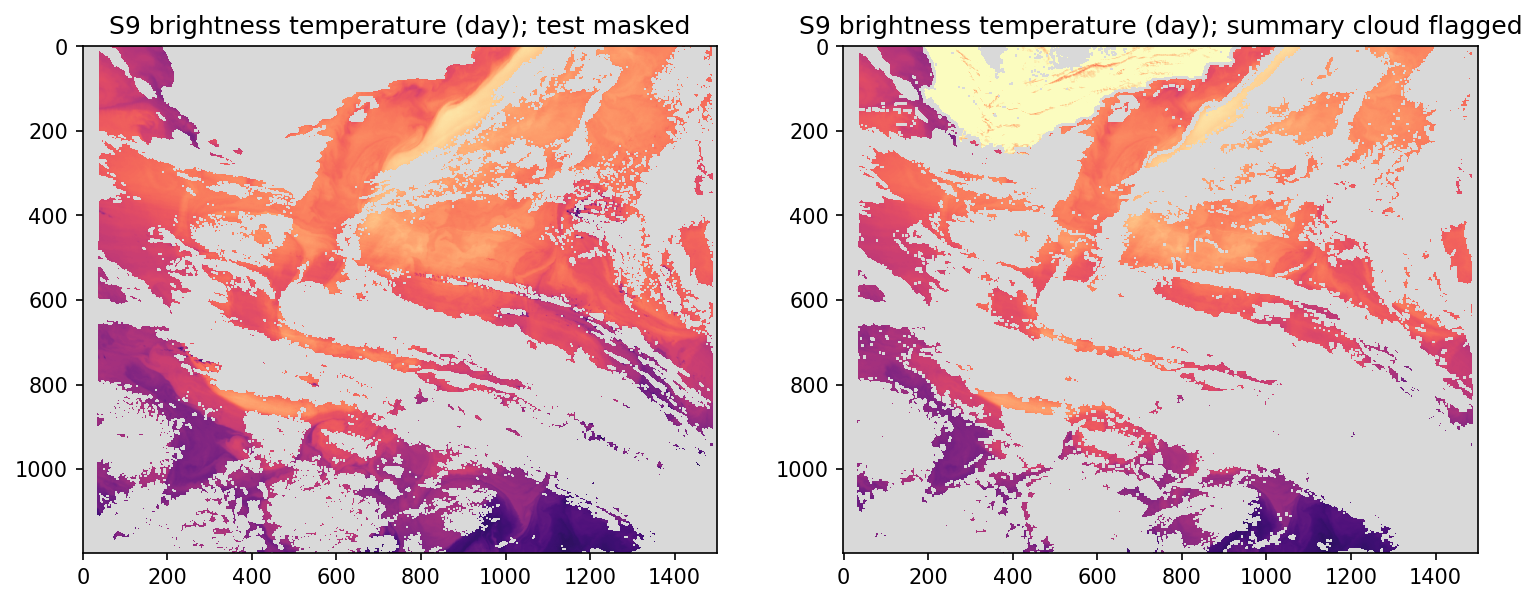

In [21]:
# S5 threshold [mW.m^-2.sr^-1.nm^-1]
threshold_value = 2

test_var = np.array(band_dict[f"S9_BT_in"])
cloud_mask = np.zeros(np.shape(band_dict[f"S5_radiance_an"]))
cloud_mask[np.array(band_dict[f"S5_radiance_an"]) > threshold_value] = np.nan

# downscale the mask from 500 m to 1000 m
cloud_mask = cloud_mask[::2, ::2]

test_var[np.isnan(cloud_mask)] = np.nan

fig, axs = plt.subplots(1, 2, figsize=(12, 10), dpi=150)
c = axs[0].imshow(test_var, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[0].set_facecolor("0.85")
axs[0].title.set_text('S9 brightness temperature (day); test masked')
c = axs[1].imshow(cloud_var, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[1].set_facecolor("0.85")
axs[1].title.set_text('S9 brightness temperature (day); summary cloud flagged')

<div class="alert alert-block alert-warning">

### Challenge:

Not bad! The test mask (left) has some consistency with that on the right. But perhaps you can do better? Adjust the threshold and see if you can improve the visible mask!
    
**Why might this approach not work in all circumstances?**
<div>

Second, lets try a method based on the assumption that **clouds are cold**. Again, we will define a mask basked on a threshold, but this time we will use only the thermal channels. We will initially assume that anything colder than 10 $^{o}C$ (including the effects of the atmophere) is clouds. The box below will make the comparative plots for us

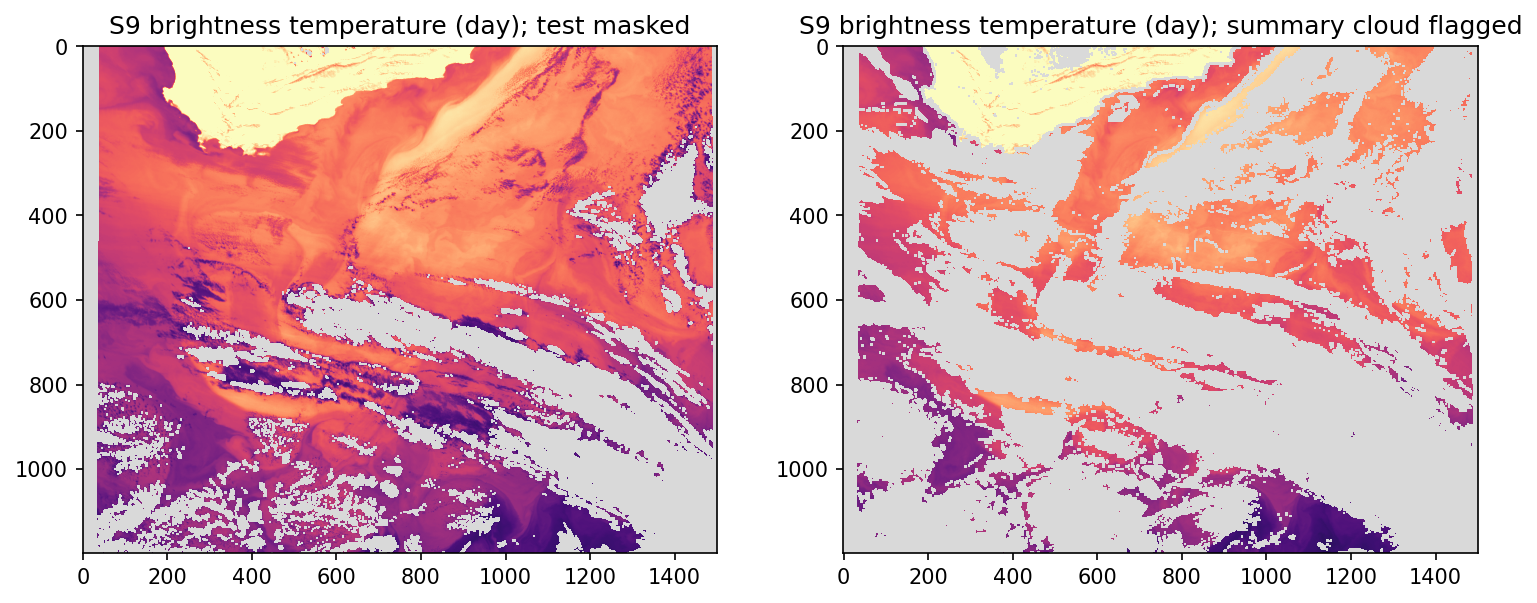

In [22]:
# S9 threshold [K]
threshold_value = 271.35 + 10

test_var = np.array(band_dict[f"S9_BT_in"])
test_var[test_var < threshold_value] = np.nan

fig, axs = plt.subplots(1, 2, figsize=(12, 10), dpi=150)
c = axs[0].imshow(test_var, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[0].set_facecolor("0.85")
axs[0].title.set_text('S9 brightness temperature (day); test masked')
c = axs[1].imshow(cloud_var, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
axs[1].set_facecolor("0.85")
axs[1].title.set_text('S9 brightness temperature (day); summary cloud flagged')

<div class="alert alert-block alert-warning">

### Challenge:

Clearly this does not work as well as the visible test, however we can use this approach night and day (unlike the visible channel method). Again perhaps you can do better? Adjust the threshold and see if you can improve the thermal mask!
    
<div>

In practice, cloud flagging is an extremely complex procedure and an active focus for operational improvement. However, it remains absolutely essential for our eventual goal of retrieveing reliable SSTs. You can learn more about ongoing studies to improve cloud flagging on the <a href="https://www.eumetsat.int/evolution-slstr-bayesian-cloud-detection-coastal-zones" target="_blank">EUMETSAT website</a>.

<div class="alert alert-info" role="alert">

## <a id='section6'></a>Step 6: Comparing the level-2 and level-4 data
[Back to top](#TOC_TOP)

</div>

In our last section, we will compare SST data at different processing levels. In Figure 2 (below) you can see the final, maximum quality Level-2 SLSTR SST that we can retrieve from the product we have been working with above. The first thing you notice is that we have lost a significant amount of data. The worse news is that this is, in fact, a very good image! Most are not this clear, especially above western boundary currents, where high latent heat flux tends to generate clouds. Consequently, we tend to merge the results of multiple sensors to get better coverage.

<div style="align: left; text-align:center;">
    <div class="caption">Figure 2: Fully flagged, dual view, bias corrected Level-2 SLSTR SST.</div>
    <img src="../img/SST_q5_flagged_dv.png" width="600px" />
</div>

Lets begin by looking at what SLSTR coverage we have in this region for 1 day. We can do this by reading all the required data from the manifest files we downloaded at the start of this notebook. The box below with gather all of this information and make a plot.

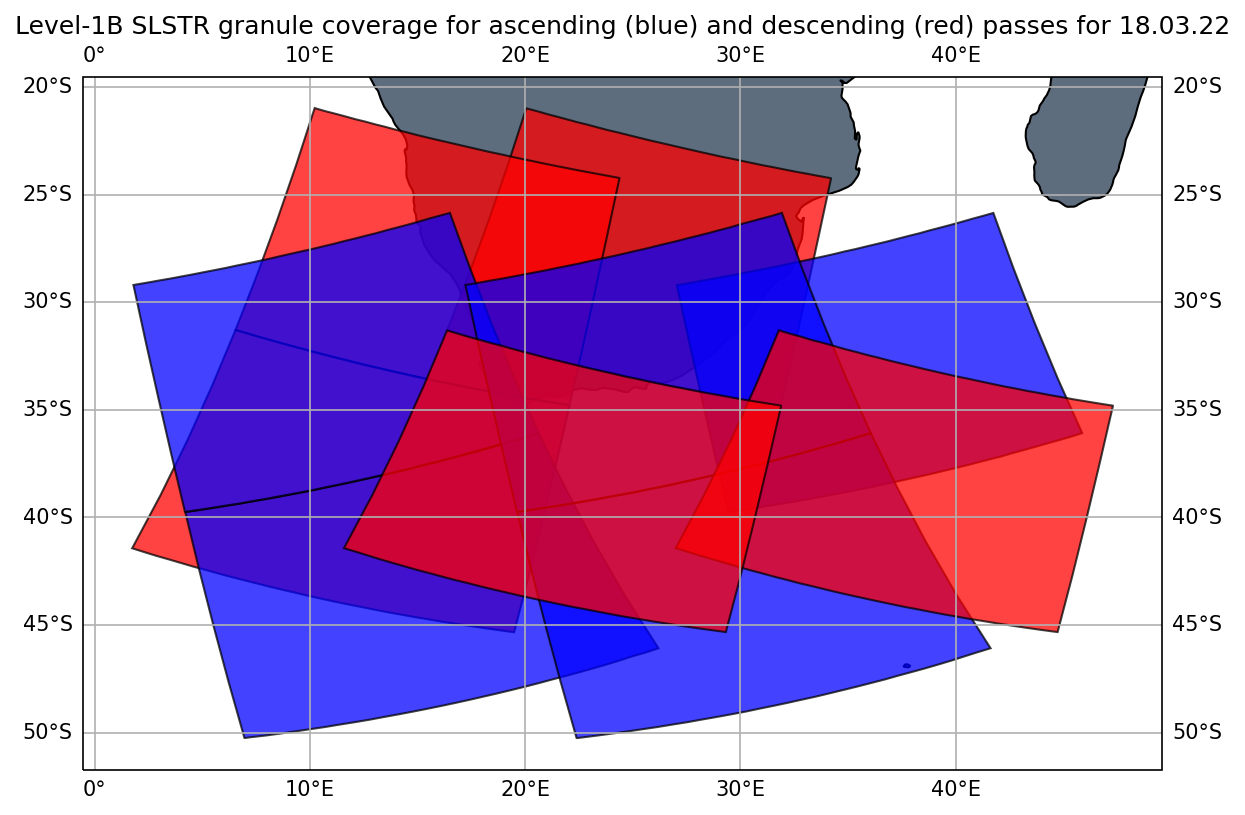

In [23]:
# selecting SAFE manifest
SAFE_manifests = glob.glob(os.path.join(download_dir, 'xfd*.xml'))

fig, m = plt.subplots(1, 1, figsize=(12, 6), dpi=150, subplot_kw={"projection": cartopy.crs.PlateCarree()})
m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
gl = m.gridlines(draw_labels = True)

for SAFE_manifest in SAFE_manifests:
    tree = ET.parse(SAFE_manifest)
    root = tree.getroot()
    polygon = root.findall('.//gml:posList', {'gml':"http://www.opengis.net/gml"})[0].text
    pass_dir = root.findall('.//sentinel-safe:passNumber',
                        {'sentinel-safe':"http://www.esa.int/safe/sentinel/1.1"})[0].attrib['groundTrackDirection']
    coords = np.asarray(polygon.split(' ')).astype('float')
    if pass_dir == "descending":    
        polygon_geom = Polygon(zip((coords[1::2]), coords[0::2]))
        colour='r'
    else:
        polygon_geom = Polygon(zip((coords[1::2][::-1]), coords[0::2][::-1]))
        colour='b'
    x, y = polygon_geom.exterior.xy
    p, = plt.fill(x, y, alpha=0.74, fc=colour, ec='k', transform=cartopy.crs.Geodetic())
plt.title('Level-1B SLSTR granule coverage for ascending (blue) and descending (red) passes for 18.03.22');

As you can see, we have ~10 granules for SLSTR. However, in reality there are many SST sensors in operations! Level-4 OSTIA products below combines data from SLSTR, AVHRR18, AVHRR19, AVHRR_METOP_B, VIIRS_NPP, AMSR2, GOES13 and SEVIRI, along with NCEP and OSI-SAF sea ice records! At level-4 we have homogenised all of these sensors onto a single grid and employed some statistical methodology to fill in any gaps due to remaining cloud. Lets take a look at two example OSTIA products; one for skin temperature and one for foundation temperature.

First we will read in the data...

In [24]:
# selecting OSTIA products
OSTIA_foundation_file = os.path.join(os.getcwd(), 'OSTIA', 'OSTIA_foundation_temperature_18032022.nc')
OSTIA_skin_file = os.path.join(os.getcwd(), 'OSTIA', 'OSTIA_skin_temperature_18032022_0730.nc')

# opening the products
OSTIA_fSST = xr.open_dataset(OSTIA_foundation_file)
OSTIA_sSST = xr.open_dataset(OSTIA_skin_file)

And then we will make the two plots...

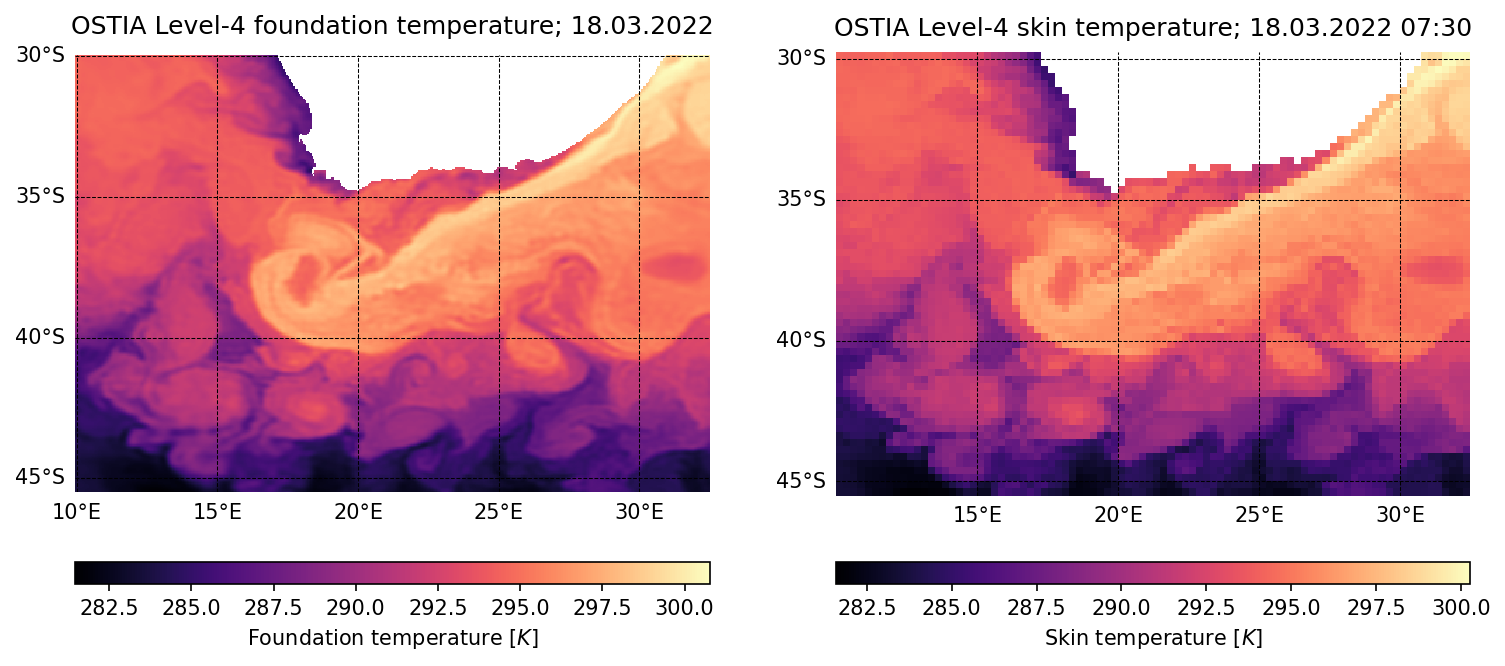

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=150, subplot_kw={"projection": cartopy.crs.PlateCarree()})

labels = ['Foundation temperature [$K$]', 'Skin temperature [$K$]']
titles = ['OSTIA Level-4 foundation temperature; 18.03.2022', 'OSTIA Level-4 skin temperature; 18.03.2022 07:30']
products = [OSTIA_fSST, OSTIA_sSST]

for m, product, label, title in zip(axs, products, labels, titles):
    c = m.pcolormesh(product["lon"], product["lat"], np.squeeze(product["analysed_sst"]), cmap=plt.cm.magma)
    m.title.set_text(title)
    embellish_plot(m)    
    cb_ax = fig.add_axes([m.get_position().x0, 0.15, m.get_position().width, 0.025])
    fig.colorbar(c, cax=cb_ax, orientation="horizontal", label=label);

As you can see, we have (by design!) complete coverage! These records are often much easier to work with. They are cloud free, on a regular grid, and often available at much higher temporal frequency.

However, there is a trade off! They are nearly always lower spatial resolution. The decisions made in the process used to combine and gap-fill the data may render them unsuitable for some users, and it is likely that they may have high errors and/or bias in highly clouded regions or along coasts.

So, take care! There are many SST options available, and you should take care to find the right one for the job; not just the easiest to use!

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_SLSTR_advanced/2_1_SLSTR_advanced_data_access_eumdac.ipynb" target="_blank"><< Advanced SLSTR data access with the EUMDAC client</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean" target="_blank">View on GitLab</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>